# Dynamic Time Warping (DTW) distance

Solo pretendo echar un vistazo a esta metrica de similitud para series temporales. Las tareas a realizar son las siguientes:
- Definicion de ventanas para datos con patrones diarios (ej. temperature) y para datos totalmente estocasticos (ej. viento).
- Probar librerias ya hechas para el calculo de DTW: con y sin bandas.

In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd

### functions

In [2]:
# data windows selector
def wdata(wd_number:int, data:'df', windows:'df'):
    i, f = windows[windows.number == wd_number][['index_i', 'index_f']].values.ravel()
    return data.iloc[i:f]

### dataset

In [4]:
# load data
sys.path.append('../')  
from datasets import weather
dataset, dcol = weather.load()
print(dcol.all)
# format index
dataset.index = pd.to_datetime(dataset.index)

Load data..
['RH (%)', 'WD', 'WS (m/s)', 'cloud_coverage', 'dew_point (degC)', 'irradiation (MJ/m2)', 'local_press (hPa)', 'precipitation (mm)', 'sea-level pressure (hPa)', 'sunlight_duration (h)', 'temperature (degC)', 'vapor_press (hPa)', 'visibility (km)']


## WINDOWS DEFINITIONS

### Option 1: DAILY (for temperature)

In [5]:
# collect data
varname = 'temperature (degC)'
data1 = dataset[[varname]].rename(columns = {varname:'var'})
print('It was collected: "%s"'%varname)

It was collected: "temperature (degC)"


In [6]:
# data preparation
df = data1.copy()
df = df.resample("H").asfreq()
df['id'] = list(range(len(df)))
df['hour'] = [idt.hour for idt in df.index.tolist()]
# initial indexes of each windows
wd_i = df[df.hour == 0].id.values
# final indexes of each windows
wd_f = wd_i + 23 + 1
# number of windows
wd_num = np.array(range(len(wd_i))) + 1
# create windows df
windows1 = pd.DataFrame({'number':wd_num, 'index_i': wd_i, 'index_f': wd_f})

### Option 2: NON-DAILY (for wind speed)

Mas adelante.

## CHECK wtd library without bands ([source](https://github.com/pierre-rouanet/dtw))

In [8]:
# select data to be used
windows = windows1.copy()
data = data1.copy()

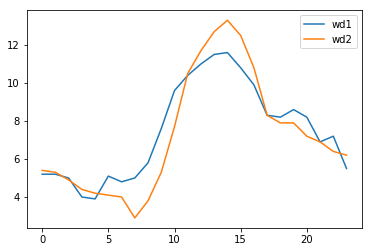

In [26]:
# select 2 windows and collect their data
nwd1 = 1
nwd2 = 2
wd1 = wdata(nwd1, data, windows)
wd2 = wdata(nwd2, data, windows)
# plot selection
pd.concat([wd1.reset_index().rename(columns={'var':'wd1'}), wd2.reset_index().rename(columns={'var':'wd2'})], axis = 1)[['wd1','wd2']].plot()

### define distance function

In [46]:
##Euclidean Distance
from numpy.linalg import norm
distance = lambda x, y: norm(x - y)

### compute DTW

In [47]:
from dtw import dtw
# data
x = wd1['var'].values.ravel()
y = wd2['var'].values.ravel()
# compute dtw
dist, cost, acc, path = dtw(x, y, dist=distance)
dist

0.26874999999999999

### plot

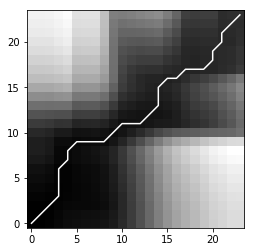

In [48]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.imshow(acc.T, origin='lower', cmap=cm.gray, interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlim((-0.5, acc.shape[0]-0.5))
plt.ylim((-0.5, acc.shape[1]-0.5))
plt.show()

### look for the N most similar windows to a target windows

In [65]:
def rank_dwt(nwd_target, nwd_historical, distance):
    # collect windows data
    x = wdata(nwd_target, data, windows)['var'].values
    y = wdata(nwd_historical, data, windows)['var'].values
    # compute and return
    return dtw(x, y, dist=distance)[0]

In [80]:
# select windows: Target and Historical
nwd_target = 1#windows.number.values[-1]
windows_historical = windows[~windows.number.isin([nwd_target])]
# calculate dwt
windows_historical['dwt'] = windows_historical['number'].apply(lambda x: rank_dwt(nwd_target, x, distance))
# sort by dwt values
windows_historical.sort_values(['dwt'], ascending=[1], inplace=True)

/home/juan/miniconda3/envs/mltools/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/juan/miniconda3/envs/mltools/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [81]:
windows_historical.head()

,number,index_i,index_f,dwt
421,422,10104,10128,0.183333
691,692,16584,16608,0.191667
449,450,10776,10800,0.222917
8,9,192,216,0.237500
706,707,16944,16968,0.247917


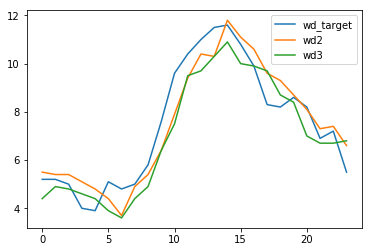

In [87]:
wdx1 = wdata(nwd_target, data, windows)
wdx2 = wdata(422, data, windows)
wdx3 = wdata(692, data, windows)
# plot selection
pd.concat([wdx1.reset_index().rename(columns={'var':'wd_target'}), 
           wdx2.reset_index().rename(columns={'var':'wd2'}), 
           wdx3.reset_index().rename(columns={'var':'wd3'})], axis = 1)[['wd_target','wd2','wd3']].plot()